In [1]:
import os
import json
import pandas as pd
from typing import Dict, Any
from urllib.request import urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely import wkt
import openrouteservice
import polars as pl
import os
from IPython.core.interactiveshell import InteractiveShell

from IPython.display import display_html
InteractiveShell.ast_node_interactivity = "all"

auhouseprices_dir = '../data/raw/auhouseprices/'

In [2]:
# Read each .csv file in the directory into a single polars DataFrame
df = pl.DataFrame({})
for file in os.listdir(auhouseprices_dir):
    if file.endswith('.csv'):
        df = df.vstack(pl.read_csv(auhouseprices_dir + file))


In [3]:
pd = df.to_pandas()
pd = pd.rename(columns={'sold_date': 'Listing date'})

In [4]:
pd

,unique_id,street_name,state,postcode,suburb,property_type,address,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,Listing date,latitude,longitude
0,33228344,Vanberg Road,VIC,3040.0,Essendon,Townhouse,"5/61 Vanberg Road, Essendon VIC 3040",400.0,3.0,1.0,1.0,7.09,Dec 2012,-37.754148,144.934050
1,34904767,carramar st,VIC,3337.0,Melton West,house,"24 carramar st, Melton West VIC 3337",449.0,4.0,2.0,2.0,39.40,Mar 2015,-37.664852,144.556370
2,33168175,None,VIC,3550.0,Bendigo,House,"2A,3 Stone Street, Bendigo VIC 3550",270.0,3.0,1.0,2.0,134.93,Jun 2013,-36.738890,144.254916
3,34938488,City Road,VIC,3006.0,Southbank,apartment,"3304/283 City Road, Southbank VIC 3006",585.0,2.0,2.0,1.0,1.56,Apr 2015,-37.827305,144.959050
4,33957241,Hillview Avenue,VIC,3178.0,Rowville,house,"3 Hillview Avenue, Rowville VIC 3178",390.0,3.0,1.0,2.0,26.46,Mar 2015,-37.920490,145.232380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,311214861,Cochrane Street,VIC,3186.0,Brighton,house,"110 Cochrane Street, Brighton VIC 3186",650.0,3.0,2.0,2.0,9.70,Sep 2016,-37.895790,145.000020
899996,311214873,Maroona Road,VIC,3163.0,Carnegie,house,"1/20 Maroona Road, Carnegie VIC 3163",405.0,2.0,1.0,1.0,11.21,Nov 2016,-37.889412,145.047320
899997,311214878,Dewar Crescent,VIC,3340.0,Bacchus Marsh,house,"25 Dewar Crescent, Bacchus Marsh VIC 3340",360.0,4.0,2.0,2.0,50.05,Jul 2016,-37.690685,144.415370
899998,311214885,Lorienne Street,VIC,3135.0,Heathmont,house,"10 Lorienne Street, Heathmont VIC 3135",350.0,3.0,1.0,2.0,23.53,Jan 2017,-37.827587,145.230380


In [5]:
pd.isnull().sum()


unique_id               0
street_name         14186
state                2176
postcode             2176
suburb               2176
property_type           0
address                 0
rent                  902
num_bedrooms         6428
num_bathrooms          51
parking            138741
distance_to_cbd         0
Listing date            0
latitude               32
longitude              32
dtype: int64

In [6]:
# delete rows with negetive rent, or negetive numeric values
pd['rent'] = pd['rent'].fillna(0)
pd = pd[pd['rent'] > 0.0]
pd = pd[pd['num_bedrooms'] > 0.0]
pd = pd[pd['num_bathrooms'] > 0.0]
pd = pd[pd['parking'] >= 0.0]
pd = pd[pd['property_type'] != '']
pd['suburb'] = pd['suburb'].str.lower()
pd['property_type'] = pd['property_type'].str.lower()
pd = pd.drop("street_name", axis=1)

# num_bedrooms	num_bathrooms
# we made an assumption that the an average property would have a bathroom and a bedroom at least


In [7]:
pd.isnull().sum()
len(pd)

unique_id             0
state              1981
postcode           1981
suburb             1981
property_type         0
address               0
rent                  0
num_bedrooms          0
num_bathrooms         0
parking               0
distance_to_cbd       0
Listing date          0
latitude             31
longitude            31
dtype: int64

758896

In [8]:
# rename sold_date to date

pd = pd.dropna(subset=['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking', 'property_type', 'Listing date','longitude', 'latitude','state'])
pd = pd.drop("state", axis=1)


In [9]:
pd.isna().sum()
len(pd)
# pd[pd['street_name'].isna()]

unique_id          0
postcode           0
suburb             0
property_type      0
address            0
rent               0
num_bedrooms       0
num_bathrooms      0
parking            0
distance_to_cbd    0
Listing date       0
latitude           0
longitude          0
dtype: int64

756884

In [10]:
# how to summary for the numetrical values
pd.describe()

,unique_id,postcode,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,latitude,longitude
count,7.568840e+05,756884.000000,7.568840e+05,756884.000000,756884.000000,756884.000000,756884.000000,756884.000000,756884.000000
mean,1.680594e+08,3249.317568,1.102127e+03,2.610592,1.437226,1.543016,193.016534,-37.366717,143.431263
std,1.398678e+08,274.012663,5.698026e+05,1.202533,0.571730,1.245691,1475.314848,3.952776,14.895703
min,3.035450e+05,3000.000000,1.000000e+00,1.000000,1.000000,1.000000,0.030000,-41.294499,-123.369898
25%,3.480882e+07,3064.000000,3.200000e+02,2.000000,1.000000,1.000000,8.230000,-37.918380,144.886389
50%,3.990808e+07,3152.000000,3.750000e+02,3.000000,1.000000,1.000000,18.360000,-37.829268,145.001283
75%,3.114808e+08,3228.000000,4.600000e+02,3.000000,2.000000,2.000000,41.370000,-37.747135,145.126770
max,3.320003e+08,3996.000000,4.956113e+08,650.000000,52.000000,410.000000,17034.200000,200.000000,200.000000


In [11]:
# outlier analysis

# graph histogram for rent and zoom in
def plothisto(col,logornot=False):
    if logornot:
        pd[col].apply(np.log).hist(bins=100)
    else:
        pd[col].hist(bins=100)
    plt.show()

# now graph its log


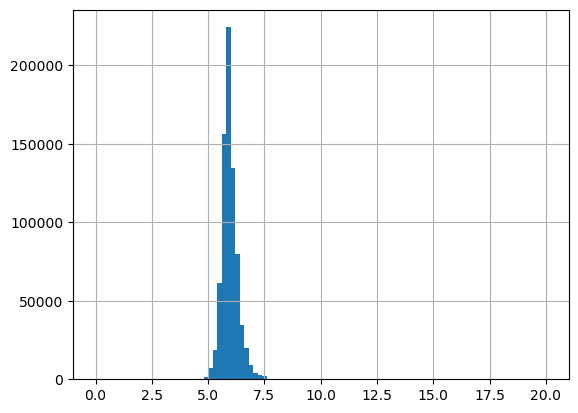

In [12]:
x = 'rent'

plothisto(x,True)

In [13]:
# how to remove to 95 percentile
print(pd['rent'].quantile(0.9999))
print(pd['distance_to_cbd'].quantile(0.9999))
print(pd['num_bedrooms'].quantile(0.9999))
print(pd['num_bathrooms'].quantile(0.9999))
print(pd['parking'].quantile(0.9999))

pd = pd[pd['rent'] < pd['rent'].quantile(0.9999)]
pd = pd[pd['distance_to_cbd'] < pd['distance_to_cbd'].quantile(0.99999)]
pd = pd[pd['num_bedrooms'] < pd['num_bedrooms'].quantile(0.9999)]
pd = pd[pd['num_bathrooms'] < pd['num_bathrooms'].quantile(0.9999)]
pd = pd[pd['parking'] < pd['parking'].quantile(0.9999)]

# pd = pd[pd[x] < pd[x].quantile(0.95)]


4500.0
14488.47
9.0
8.0
13.0


In [14]:
print(pd.isna().sum())
print(len(pd))



unique_id          0
postcode           0
suburb             0
property_type      0
address            0
rent               0
num_bedrooms       0
num_bathrooms      0
parking            0
distance_to_cbd    0
Listing date       0
latitude           0
longitude          0
dtype: int64
756526


In [15]:
pd.describe()

,unique_id,postcode,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,latitude,longitude
count,7.565260e+05,756526.000000,756526.000000,756526.000000,756526.000000,756526.000000,756526.000000,756526.000000,756526.000000
mean,1.680595e+08,3249.281485,419.962391,2.607839,1.435852,1.537956,192.617839,-37.368159,143.435643
std,1.398678e+08,273.991512,197.049232,0.927707,0.558234,0.780881,1473.273773,3.941407,14.869247
min,3.035450e+05,3000.000000,1.000000,1.000000,1.000000,1.000000,0.030000,-41.294499,-123.369898
25%,3.480898e+07,3064.000000,320.000000,2.000000,1.000000,1.000000,8.230000,-37.918380,144.886401
50%,3.990810e+07,3152.000000,375.000000,3.000000,1.000000,1.000000,18.350000,-37.829280,145.001270
75%,3.114809e+08,3228.000000,460.000000,3.000000,2.000000,2.000000,41.360000,-37.747185,145.126740
max,3.320003e+08,3996.000000,4200.000000,8.000000,6.000000,12.000000,16913.640000,200.000000,200.000000


In [16]:
pd.to_csv('../data/raw/preprocessing_houseprices.csv', index=False)

,unique_id,postcode,suburb,property_type,address,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,Listing date,latitude,longitude
0,33228344,3040.0,essendon,townhouse,"5/61 Vanberg Road, Essendon VIC 3040",400.0,3.0,1.0,1.0,7.09,Dec 2012,-37.754148,144.934050
1,34904767,3337.0,melton west,house,"24 carramar st, Melton West VIC 3337",449.0,4.0,2.0,2.0,39.40,Mar 2015,-37.664852,144.556370
2,33168175,3550.0,bendigo,house,"2A,3 Stone Street, Bendigo VIC 3550",270.0,3.0,1.0,2.0,134.93,Jun 2013,-36.738890,144.254916
3,34938488,3006.0,southbank,apartment,"3304/283 City Road, Southbank VIC 3006",585.0,2.0,2.0,1.0,1.56,Apr 2015,-37.827305,144.959050
4,33957241,3178.0,rowville,house,"3 Hillview Avenue, Rowville VIC 3178",390.0,3.0,1.0,2.0,26.46,Mar 2015,-37.920490,145.232380
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,311214861,3186.0,brighton,house,"110 Cochrane Street, Brighton VIC 3186",650.0,3.0,2.0,2.0,9.70,Sep 2016,-37.895790,145.000020
899996,311214873,3163.0,carnegie,house,"1/20 Maroona Road, Carnegie VIC 3163",405.0,2.0,1.0,1.0,11.21,Nov 2016,-37.889412,145.047320
899997,311214878,3340.0,bacchus marsh,house,"25 Dewar Crescent, Bacchus Marsh VIC 3340",360.0,4.0,2.0,2.0,50.05,Jul 2016,-37.690685,144.415370
899998,311214885,3135.0,heathmont,house,"10 Lorienne Street, Heathmont VIC 3135",350.0,3.0,1.0,2.0,23.53,Jan 2017,-37.827587,145.230380
